# Plot RSAM & DSAR with respect to station location

In [1]:
import numpy as np
import pandas as pd
import obspy
from obspy import UTCDateTime
import obspy.signal.filter
import sys           
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import math
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('../../MtStHelens_activity/mt_st_helens_activity.txt', header=1, skiprows=11)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)

activity_dome = df_activity.copy()
activity_dome_start = activity_dome[activity_dome['activity' ]=='d'].take([0,2,3,4,5,6])
activity_dome_end = activity_dome[activity_dome['activity' ]=='ed'].take([1,2,3,4,5,6])
activity_dome_start, activity_dome_end

(           activity
 UTC                
 2004-10-11        d
 2004-10-25        d
 2005-01-03        d
 2005-03-19        d
 2005-08-06        d
 2005-10-09        d,
            activity
 UTC                
 2004-10-24       ed
 2004-12-18       ed
 2005-03-09       ed
 2005-07-18       ed
 2005-10-09       ed
 2006-04-01       ed)

In [3]:
def distance(lat1, lat2, lon1, lon2):
    '''input: latitude and longitude of two points in degree
       output: distance between two points in kilometers'''
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = math.radians(lon1)
    lon2 = math.radians(lon2)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
 
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [4]:
# load station coordinates and drop the stations which are not of interresst
all_files = sorted(glob.glob('../data/*_*_extended2.csv'))
sta_list = np.unique([file.split('/')[2].split('_')[1] for file in all_files]) # stations with data

df = pd.read_csv('/home/koepflma/project1/Mt-St-Helens/sta_log_long.txt', sep='|', header=0) # coordinates
df = df[~df['Station'].isin(list(set(df.Station)-set(sta_list)))] # delete Stations which are not of interresst
df = df.drop_duplicates(subset=['Station']) # drop one station if the station is not unique
df = df.reset_index(drop=True)
df

,Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime
0,CC,BLIS,46.197472,-122.186569,2116.00,"Blister, Mt. St. Helens (Dome sta)",2004-10-12T00:00:00,2005-02-17T00:00:00
1,CC,HOA,46.241780,-122.191830,1151.00,Hoala,2021-06-08T00:00:00,2599-12-31T23:59:59
2,CC,JRO,46.275270,-122.218260,1219.00,Johnston Ridge Observatory,2004-10-02T00:00:00,2599-12-31T23:59:59
3,CC,LOO,46.223750,-122.184390,1521.35,Loowit,2021-06-08T00:00:00,2599-12-31T23:59:59
4,CC,MIDE,46.197750,-122.187439,2132.00,Near old BLIS MSH,2005-02-16T00:00:00,2005-07-26T00:00:00
5,CC,NED,46.200249,-122.185493,2060.00,"NE part of old Dome, Mt. St. Helens (Dome sta)",2004-11-20T00:00:00,2013-05-01T00:00:00
6,CC,RAFT,46.195679,-122.186317,2132.00,"RAFT, St Helens Crater",2005-07-28T00:00:00,2007-12-31T00:00:00
7,CC,REM,46.200200,-122.185500,1905.44,"Rembrant, Mount St. Helens",2018-07-25T00:00:00,2599-12-31T23:59:59
8,CC,SEP,46.199780,-122.190857,2114.00,"September lobe, Mt. St. Helens (Dome sta)",2004-11-05T00:00:00,2599-12-31T23:59:59
9,CC,SPN5,46.194698,-122.188370,2263.00,"Spine 5, St Helens Crater, WA",2007-06-18T00:00:00,2007-12-31T00:00:00


In [5]:
ref_sta = 'SEP' # define the reference station, we will get distance from all other stations to this station
df['dist'] = df.apply(lambda x: distance(x['Latitude'],df.Latitude[df['Station']==ref_sta] , x['Longitude'],df.Longitude[df['Station']==ref_sta] ), axis=1)
df = df.sort_values(by=['dist'])
sta_sorted = df['Station'].to_list()
df

,Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime,dist
8,CC,SEP,46.199780,-122.190857,2114.00,"September lobe, Mt. St. Helens (Dome sta)",2004-11-05T00:00:00,2599-12-31T23:59:59,0.000000
4,CC,MIDE,46.197750,-122.187439,2132.00,Near old BLIS MSH,2005-02-16T00:00:00,2005-07-26T00:00:00,0.346634
7,CC,REM,46.200200,-122.185500,1905.44,"Rembrant, Mount St. Helens",2018-07-25T00:00:00,2599-12-31T23:59:59,0.414926
5,CC,NED,46.200249,-122.185493,2060.00,"NE part of old Dome, Mt. St. Helens (Dome sta)",2004-11-20T00:00:00,2013-05-01T00:00:00,0.416109
0,CC,BLIS,46.197472,-122.186569,2116.00,"Blister, Mt. St. Helens (Dome sta)",2004-10-12T00:00:00,2005-02-17T00:00:00,0.418066
6,CC,RAFT,46.195679,-122.186317,2132.00,"RAFT, St Helens Crater",2005-07-28T00:00:00,2007-12-31T00:00:00,0.574494
9,CC,SPN5,46.194698,-122.188370,2263.00,"Spine 5, St Helens Crater, WA",2007-06-18T00:00:00,2007-12-31T00:00:00,0.596632
28,UW,YEL,46.209549,-122.188988,1750.00,"Yellow Rock, Mt. St. Helens",1981-10-01T00:00:00,2007-09-18T00:00:00,1.095744
12,CC,SWFL,46.188670,-122.202030,2268.00,Southwest Flank,2006-10-01T00:00:00,2013-08-28T00:00:00,1.505239
14,CC,VALT,46.214218,-122.189247,1681.00,"Vault, Mount St. Helens",2006-09-30T00:00:00,2599-12-31T23:59:59,1.610206


### Load the data

In [28]:
# load data and define times as index and make them to timestamp
df_rsam_median = pd.read_csv('../data/rsam_extended2_long.csv', index_col='time', parse_dates=True, infer_datetime_format=True)
df_mf_median = pd.read_csv('../data/mf_extended2_long.csv', index_col='time', parse_dates=True, infer_datetime_format=True)
df_hf_median = pd.read_csv('../data/hf_extended2_long.csv', index_col='time', parse_dates=True, infer_datetime_format=True)
# df_zscrsam_median = pd.read_csv('../data/zscrsam_extended2_long.csv', index_col='time', parse_dates=True, infer_datetime_format=True)
df_dsar_median = pd.read_csv('../data/dsar_extended2_long.csv', index_col='time', parse_dates=True, infer_datetime_format=True)
# df_zscdsar_median = pd.read_csv('../data/zscdsar_extended2_long.csv', index_col='time', parse_dates=True, infer_datetime_format=True)

In [29]:
# create a dict containing the dfs loaded above, key is the parameter
df_dict = {}
df_dict['rsam'] = df_rsam_median
df_dict['mf'] = df_mf_median
df_dict['hf'] = df_hf_median
# df_dict['zscrsam'] = df_zscrsam_median
df_dict['dsar'] = df_dsar_median
# df_dict['zscdsar'] = df_zscdsar_median
df_dict

{'rsam':                            SEP  NED        HSR        EDM       SHW       STD  \
 time                                                                            
 2000-01-01 00:00:00        NaN  NaN        NaN        NaN       NaN       NaN   
 2000-01-01 00:10:00        NaN  NaN        NaN        NaN       NaN       NaN   
 2000-01-01 00:20:00        NaN  NaN        NaN        NaN       NaN       NaN   
 2000-01-01 00:30:00        NaN  NaN        NaN        NaN       NaN       NaN   
 2000-01-01 00:40:00        NaN  NaN        NaN        NaN       NaN       NaN   
 ...                        ...  ...        ...        ...       ...       ...   
 2022-12-31 23:10:00  15.991046  NaN  10.355451  46.775453  7.498298  6.350997   
 2022-12-31 23:20:00  16.805397  NaN  10.043559  43.599227  7.483242  5.728005   
 2022-12-31 23:30:00  12.942276  NaN   8.342179  37.229061  6.325171  5.207771   
 2022-12-31 23:40:00   9.032227  NaN   5.324722  23.644371  3.987556  3.693433   
 2022-12

In [30]:
# sort the columns corresponding to crater distane
def sort_columns(df, column_order):
    # Filter the list to only include existing columns in the DataFrame
    valid_columns = [col for col in column_order if col in df.columns]

    # Sort the DataFrame columns based on the valid columns list
    sorted_columns = valid_columns + [col for col in df.columns if col not in valid_columns]

    # Return the DataFrame with sorted columns
    return df[sorted_columns]

df_dict_sorted = {}
for key, value in df_dict.items():
    
    # column names and drop too short stations
    value = value.rename(columns={"YEL/VALT": "YEL"})
    value = value.drop(['NED','JRO'], axis=1)
    
    # select time of interest
    value = value.loc[(value.index >= '2004-01-01') & (value.index < '2009-01-01')]
    
    # resample
    value = value.resample('1D').median()
    
    # rolling
    value = value.rolling('10D', center=True).median()
    
    # Sort the columns based on the desired order
    df_sorted = sort_columns(value, sta_sorted)
    df_dict_sorted[key] = df_sorted


# Display the result
df_dict_sorted

{'rsam':                   SEP         YEL        HSR        EDM        SHW  \
 time                                                                 
 2004-01-01  19.965686    8.957930  14.372336   9.294926  23.784948   
 2004-01-02  18.092455    3.679372  14.611928   9.311414  25.326725   
 2004-01-03  15.538145    3.512675  14.372336   9.847289  24.091449   
 2004-01-04  12.983835    3.345979  14.132745  10.383164  25.326725   
 2004-01-05   9.435838    3.275043  13.933914  11.287384  24.091449   
 ...               ...         ...        ...        ...        ...   
 2008-12-27  46.838891   73.424777  41.418056  51.052446  32.419043   
 2008-12-28  47.052494   79.674756  42.256264  53.553025  26.231221   
 2008-12-29  47.266096   73.424777  43.094472  51.052446  20.043400   
 2008-12-30  47.355413   87.936970  46.971646  56.527611  19.359704   
 2008-12-31  47.444729  102.449163  52.525235  62.002776  20.043400   
 
                    STD        SOS        JUN        FL2        CDF

In [12]:
# normalize the stations (columns)
def normalize_columns(df):
    # Normalize each column based on its max and min values
    normalized_df = (df - df.min()) / (df.max() - df.min())
    return normalized_df

df_dict_sorted_norm = {}
for key, value in df_dict_sorted.items():
    
    # Normalize the columns
    df_norm = normalize_columns(value)
    df_dict_sorted_norm[key] = df_norm

# Display the result
df_dict_sorted_norm

{'rsam':                  SEP       YEL       HSR       EDM       SHW       STD  \
 time                                                                     
 2004-01-01  0.002155  0.002615  0.004910  0.002835  0.014805  0.008168   
 2004-01-02  0.001920  0.000839  0.005007  0.002840  0.015765  0.008258   
 2004-01-03  0.001599  0.000783  0.004910  0.003010  0.014996  0.008627   
 2004-01-04  0.001279  0.000727  0.004812  0.003181  0.015765  0.008996   
 2004-01-05  0.000833  0.000703  0.004731  0.003468  0.014996  0.013334   
 ...              ...       ...       ...       ...       ...       ...   
 2008-12-27  0.005530  0.024304  0.015929  0.016111  0.020180  0.041866   
 2008-12-28  0.005557  0.026406  0.016270  0.016906  0.016328  0.048507   
 2008-12-29  0.005583  0.024304  0.016612  0.016111  0.012476  0.055147   
 2008-12-30  0.005595  0.029186  0.018192  0.017852  0.012051  0.048387   
 2008-12-31  0.005606  0.034069  0.020454  0.019592  0.012476  0.039706   
 
               

In [31]:
# normalize the stations (columns)
def normalize_columns_by_df(df):
    # Normalize each column based on its max and min values
    # Different from normalixe_columns this function searches the min and max value of all stations
    # and normalized to these values
    normalized_df = (df - min(df.min())) / (max(df.max()) - min(df.min()))
    return normalized_df

df_dict_sorted_norm = {}
for key, value in df_dict_sorted.items():
    
    # Normalize the columns
    df_norm = normalize_columns_by_df(value)
    df_dict_sorted_norm[key] = df_norm

# Display the result
df_dict_sorted_norm

{'rsam':                  SEP       YEL       HSR       EDM       SHW       STD  \
 time                                                                     
 2004-01-01  0.002506  0.001124  0.001804  0.001167  0.002986  0.002355   
 2004-01-02  0.002271  0.000462  0.001834  0.001169  0.003179  0.002377   
 2004-01-03  0.001950  0.000441  0.001804  0.001236  0.003024  0.002467   
 2004-01-04  0.001630  0.000420  0.001774  0.001303  0.003179  0.002557   
 2004-01-05  0.001184  0.000411  0.001749  0.001417  0.003024  0.003613   
 ...              ...       ...       ...       ...       ...       ...   
 2008-12-27  0.005880  0.009217  0.005199  0.006408  0.004069  0.010563   
 2008-12-28  0.005906  0.010001  0.005304  0.006722  0.003293  0.012181   
 2008-12-29  0.005933  0.009217  0.005410  0.006408  0.002516  0.013798   
 2008-12-30  0.005944  0.011038  0.005896  0.007096  0.002430  0.012151   
 2008-12-31  0.005956  0.012860  0.006593  0.007783  0.002516  0.010037   
 
               

## Plotting

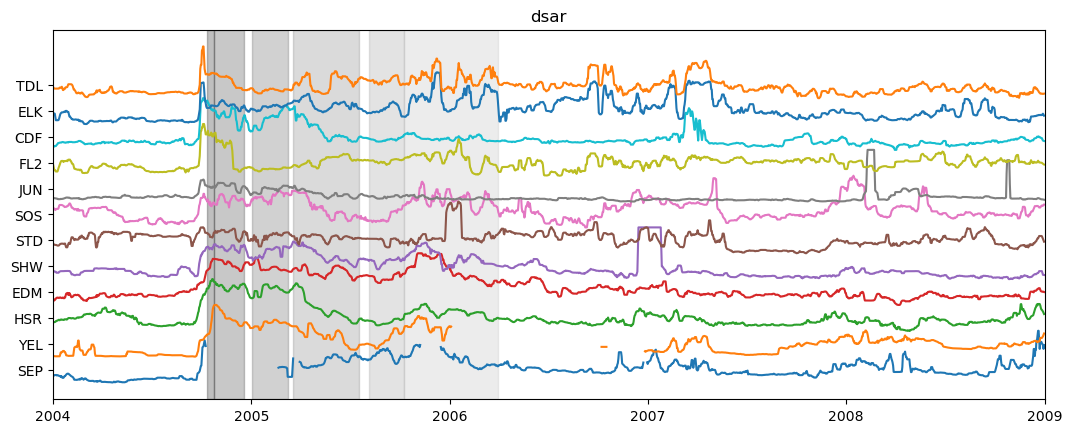

In [10]:
# Plot each column with an offset along the y-axis
param_plot = 'dsar'
year_plot = [2004, 2009]

fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
offset = 0

for col in df_dict_sorted_norm[param_plot].columns:
    y_values = df_dict_sorted_norm[param_plot][col] + offset
    ax.plot(df_dict_sorted_norm[param_plot].index, y_values, label=col)
    offset += 0.5  # Adjust the offset as needed

ax.set_yticks(np.arange(0.25,(len(df_dict_sorted_norm[param_plot].columns))/2,0.5))
ax.set_yticklabels(df_dict_sorted_norm[param_plot].columns)
    
plt.xlim([datetime.datetime(year_plot[0],1,1), datetime.datetime(year_plot[-1],1,1)])

color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

for i in range(len(activity_dome_start)):
    sdate = activity_dome_start.index[i].to_pydatetime() # start date
    edate = activity_dome_end.index[i].to_pydatetime() # end date
    ax.axvspan(sdate, edate, alpha=0.25, color=color[i])
    
plt.title(param_plot)
# plt.savefig('../plots/multiyear/multi_sta/{}_{}_{}_sorted_dome1.png'.format(year_plot[0],year_plot[-1],param_plot), dpi=300, bbox_inches='tight')
plt.show()

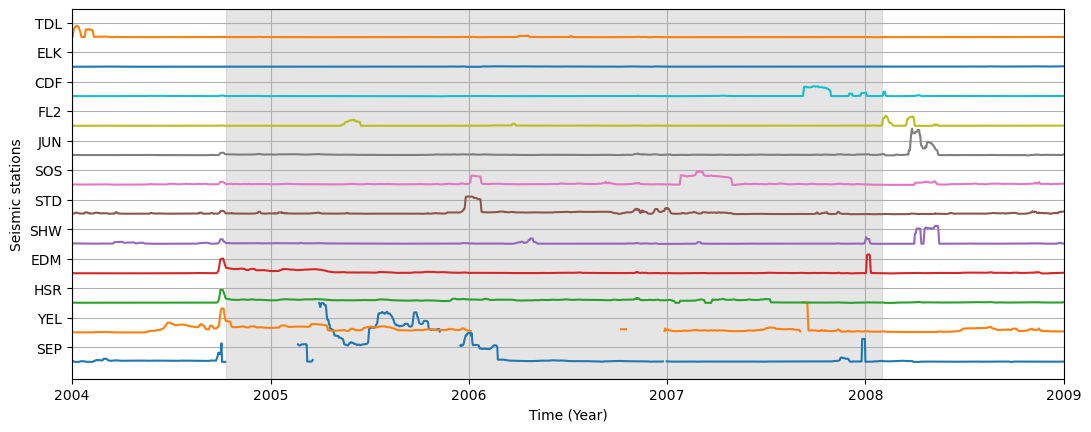

In [33]:
# Plot each column with an offset along the y-axis
param_plot = 'hf'
year_plot = [2004, 2009]

fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
offset = 0

for col in df_dict_sorted_norm[param_plot].columns:
    y_values = df_dict_sorted_norm[param_plot][col] + offset
    ax.plot(df_dict_sorted_norm[param_plot].index, y_values, label=col)
    offset += 0.5  # Adjust the offset as needed

ax.set_yticks(np.arange(0.25,(len(df_dict_sorted_norm[param_plot].columns))/2,0.5))
ax.set_yticklabels(df_dict_sorted_norm[param_plot].columns)
    
plt.xlim([datetime.datetime(year_plot[0],1,1), datetime.datetime(year_plot[-1],1,1)])

ax.axvspan(datetime.datetime(2004,10,11), datetime.datetime(2008,2,1), alpha=0.2, color='gray')
    
# plt.title(param_plot)
plt.xlabel('Time (Year)')
plt.ylabel('Seismic stations')
plt.grid()

# plt.savefig('../plots/multiyear/multi_sta/{}_{}_{}_rol10D_sorted_1dome_min_max_norm3.png'.format(year_plot[0],year_plot[-1],param_plot), dpi=300, bbox_inches='tight')
plt.show()

### Dome extrusion

In [4]:
df_dome = pd.read_csv('../../MtStHelens_activity/dome_extrusion.txt', header=0, skiprows=0)
df_dome.set_index('Date of photography',inplace=True)
df_dome.index = pd.to_datetime(df_dome.index).tz_localize(None)
# df_dome['diff'] = df_dome['Total volume change(x 106 m3)']-df_dome['Total volume change(x 106 m3)'].shift(1)
df_dome

,Total volume change(x 106 m3),Total volume change rate (m3/s),Extruded lava volume (x 106 m3),Lava extrusion rate (m3/s)
Date of photography,,,,
2004-09-23,0.0,NaN,NaN,NaN
2004-10-04,5.0,NaN,NaN,NaN
2004-10-11,10.0,8.9,NaN,NaN
2004-10-13,11.0,6.4,0.54,NaN
2004-11-04,20.0,4.6,12.00,5.90
2004-11-29,27.0,3.0,21.00,4.40
2004-12-11,30.0,3.4,26.00,4.10
2005-01-03,35.0,2.4,31.00,2.50
2005-02-01,40.0,1.9,35.00,1.80


<Axes: xlabel='Date of photography'>

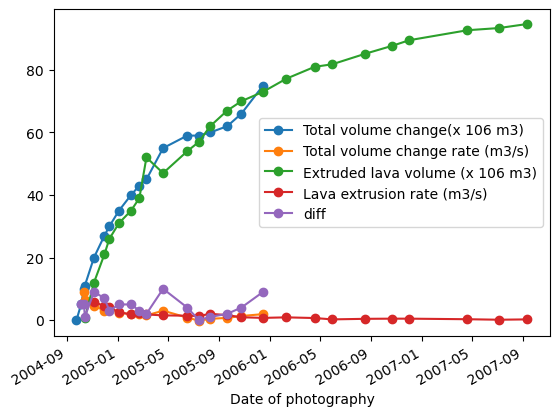

In [98]:
df_dome.plot(marker='o')

In [7]:
df_chem = pd.read_csv('../../MtStHelens_activity/emission.txt', header=0, skiprows=0)
df_chem.set_index('Date',inplace=True)
df_chem.index = pd.to_datetime(df_chem.index).tz_localize(None)
df_chem

,Platform,CO2(t/d),SO2(t/d),H2S(t/d),CO2(t),SO2(t)
Date,,,,,,
2004-09-27,Heli,50.0,1.0,0.1,NaN,NaN
2004-09-29,Heli,10.0,1.0,0.1,NaN,NaN
2004-09-30,Heli,50.0,1.0,0.1,NaN,NaN
2004-10-01,Heli,10.0,1.0,0.1,NaN,NaN
2004-10-03,Heli,50.0,1.0,0.1,NaN,NaN
2004-10-04,Heli,140.0,1.0,0.4,NaN,NaN
2004-10-07,FX,2415.0,115.0,8.0,2415.0,115.0
2004-10-11,FX,1222.0,70.0,4.0,7274.0,370.0
2004-10-13,FX,186.0,120.0,6.0,8682.0,560.0


<Axes: xlabel='Date'>

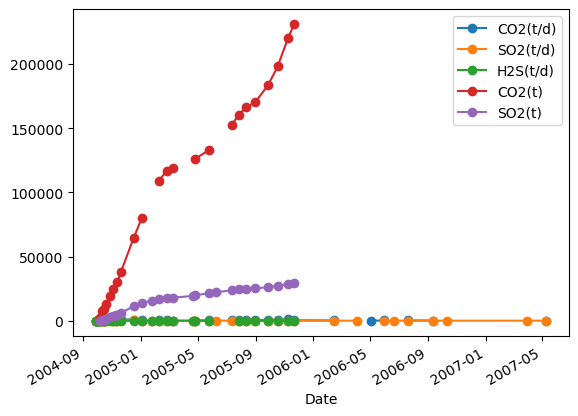

In [91]:
df_chem.plot(marker='o')

(12418.0, 14245.0)

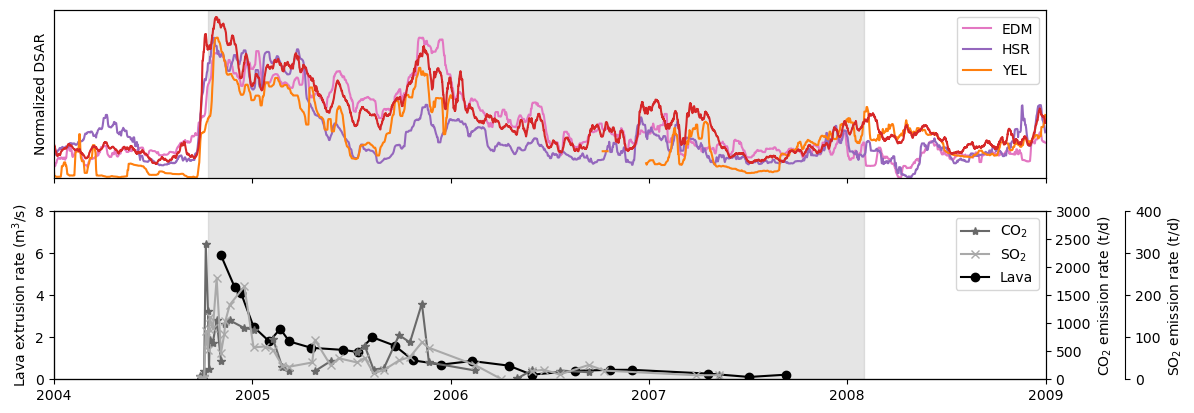

In [34]:
sta_plot = ['EDM', 'HSR', 'YEL']
col_plot = ['C6', 'C4', 'C1']
fig, (ax, ax00) = plt.subplots(2,1, sharex=True, figsize=(6.4*2, 4.8))

for i, (sta, col) in enumerate(zip(sta_plot,col_plot)):

    ax.plot(df_dict_sorted_norm[param_plot][sta], color=col, label=sta, alpha=1)

ax0 = ax.twinx()
ax0.plot(df['dsar'], color='C3', label='DSAR')

ax00.plot(np.nan, color='dimgray', marker='*', label='CO$_2$')
ax00.plot(np.nan, color='darkgray', marker='x', label='SO$_2$')

    
ax00.plot(df_dome.iloc[:,3], color='k', marker='o', label='Lava')
ax000 = ax00.twinx()
ax000.plot(df_chem.iloc[:,1], color='dimgray', marker='*')
ax0000 = ax00.twinx()
ax0000.plot(df_chem.iloc[:,2], color='darkgray', marker='x')


# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax.axvspan(sdate, edate, alpha=0.25, color=color[i])

ax.axvspan(datetime.datetime(2004,10,11), datetime.datetime(2008,2,1), alpha=0.2, color='gray')
ax00.axvspan(datetime.datetime(2004,10,11), datetime.datetime(2008,2,1), alpha=0.2, color='gray')

ax.legend(loc='upper right')
ax00.legend(loc='upper right')

ax.set_yticks([])
ax.set_ylim(0,1.2)
ax.set_ylabel("Normalized DSAR")
ax0.set_yticks([])
# ax0.set_ylim(0,3)
# ax0.set_ylabel("DSAR")
ax00.set_ylim(0,8)
ax00.set_ylabel("Lava extrusion rate (m$^3$/s)")
ax000.set_ylim(0,3000)
ax000.set_ylabel("CO$_2$ emission rate (t/d)")
ax0000.set_ylim(0,400)
ax0000.set_ylabel("SO$_2$ emission rate (t/d)")

# ax000.spines.right.set_position(("axes", 1.06))
ax0000.spines.right.set_position(("axes", 1.08))

ax.set_xlim(datetime.datetime(year_plot[0],1,1), datetime.datetime(year_plot[-1],1,1))

# plt.savefig('../../MtStHelens_activity/plot_dome_extrusion/{}_{}_{}_dome_extrusion_rate_final.png'
#             .format(year_plot[0],year_plot[-1],param_plot), dpi=300, bbox_inches='tight')

In [5]:
sta = 'allUWsta' # allUWsta, YEL_VALT
# read seismic data -------------------------------------------------------------------------------------------------------------------
# df = pd.read_csv('../data/1980_{}_extended2.csv'.format(sta)) # 1 year long
df = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df_read = df.resample('10min').median()
df = df_read.copy()
df = df.rolling('10D',center=True).median()

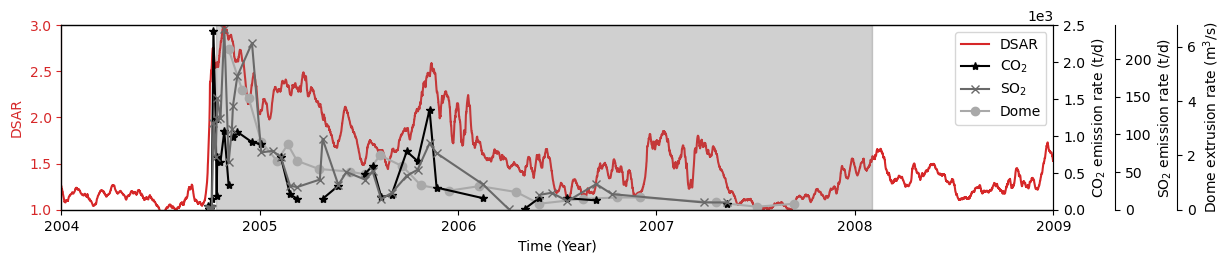

In [19]:
fig, (ax) = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8*0.5))

ax.plot(df['dsar'], color='C3', label='DSAR')
# ax.plot(np.nan, color='C3', label='RSAM')
# ax0 = ax.twinx()
# ax0.plot(df['rsam'], color='C0', label='RSAM')
ax.plot(np.nan, color='k', marker='*', label='CO$_2$')
ax.plot(np.nan, color='dimgray', marker='x', label='SO$_2$')
ax.plot(np.nan, color='darkgray', marker='o', label='Dome')

ax00 = ax.twinx() 
ax00.plot(df_dome.iloc[:,3], color='darkgray', marker='o')
ax000 = ax.twinx()
ax000.plot(df_chem.iloc[:,1], color='k', marker='*')
ax0000 = ax.twinx()
ax0000.plot(df_chem.iloc[:,2], color='dimgray', marker='x')


# color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

# for i in range(len(activity_dome_start)):
#     sdate = activity_dome_start.index[i].to_pydatetime() # start date
#     edate = activity_dome_end.index[i].to_pydatetime() # end date
#     ax.axvspan(sdate, edate, alpha=0.25, color=color[i])

ax.axvspan(datetime.datetime(2004,10,11), datetime.datetime(2008,2,1), alpha=0.2, color='gray')
ax00.axvspan(datetime.datetime(2004,10,11), datetime.datetime(2008,2,1), alpha=0.2, color='gray')

ax.legend(loc='upper right')
# ax00.legend(loc='upper right')

# ax.set_yticks([])
ax.set_ylim(1.,3.)
ax.set_ylabel("DSAR", color='C3')
# color ticks and spines subplot 2
ax.spines['left'].set_color('C3')
ax.xaxis.label.set_color('C3')
ax.tick_params(axis='y', colors='C3')
# ax0.set_ylim(0,1100)
# ax0.set_ylabel("RSAM")
ax00.set_ylim(0,6.8)
ax00.set_ylabel("Dome extrusion rate (m$^3$/s)")
ax000.set_ylim(0,2500)
ax000.set_ylabel("CO$_2$ emission rate (t/d)")
ax0000.set_ylim(0,245)
ax0000.set_ylabel("SO$_2$ emission rate (t/d)")

ax0000.spines.right.set_position(("axes", 1.062))
ax00.spines.right.set_position(("axes", 1.125))

# scientific notation
ax000.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
# ax0000.ticklabel_format(axis='y', style='sci', scilimits=(2,2))

ax.set_xlim(datetime.datetime(2004,1,1), datetime.datetime(2009,1,1))
ax.set_xlabel('Time (Year)', color='k')

plt.savefig('../../MtStHelens_activity/plot_dome_extrusion/2004_2009_DSAR_dome_extrusion_rate_final3.png', dpi=300, bbox_inches='tight')

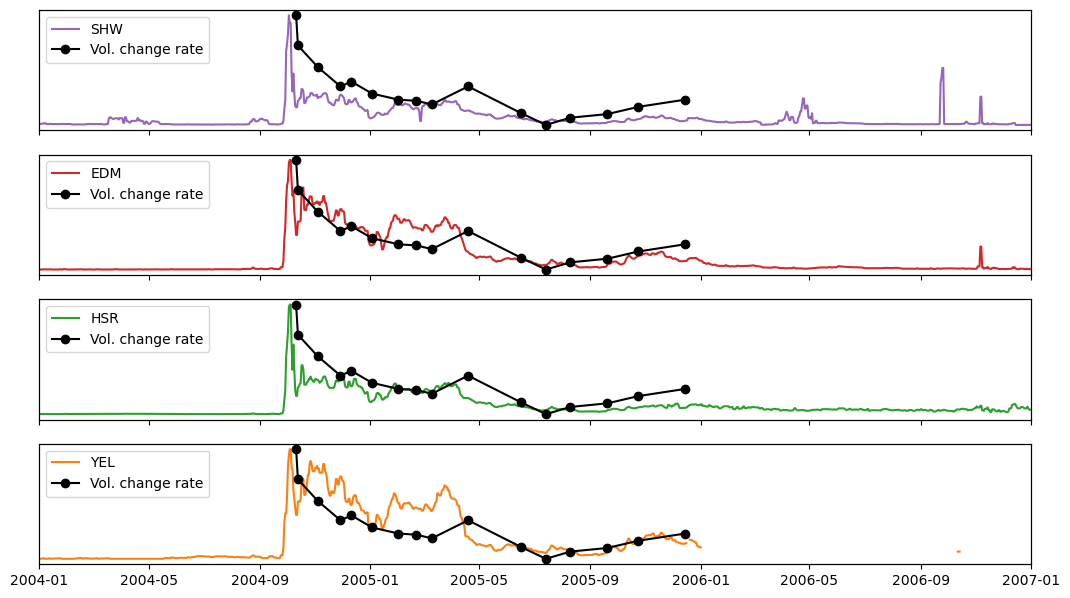

In [79]:
sta_plot = ['SHW', 'EDM', 'HSR', 'YEL']
col_plot = ['C4', 'C3', 'C2', 'C1']
fig, ax = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*1.5))

for i, (sta, col) in enumerate(zip(sta_plot,col_plot)):

    ax[i].plot(df_dict_sorted_norm[param_plot][sta], color=col, label=sta)
    ax[i].plot(np.nan, color='k', marker='o', label='Vol. change rate')
#     ax[i].plot(np.nan, color='gray', marker='o',  label='Extrusion rate')
    
    ax00 = ax[i].twinx()
    ax00.plot(df_dome.iloc[:,1], color='k', marker='o')
#     ax00.plot(df_dome.iloc[:,3], color='gray', marker='o')

    ax[i].legend(loc='upper left')
    
    ax[i].set_yticks([])
    ax00.set_yticks([])
    
ax[0].set_xlim(datetime.datetime(year_plot[0],1,1), datetime.datetime(year_plot[-1],1,1))

# plt.savefig('../../MtStHelens_activity/plot_dome_extrusion/{}_{}_{}_dome_extrusion_rate11.png'
#             .format(year_plot[0],year_plot[-1],param_plot), dpi=300, bbox_inches='tight')

### OLD Plot

(12418.0, 13514.0)

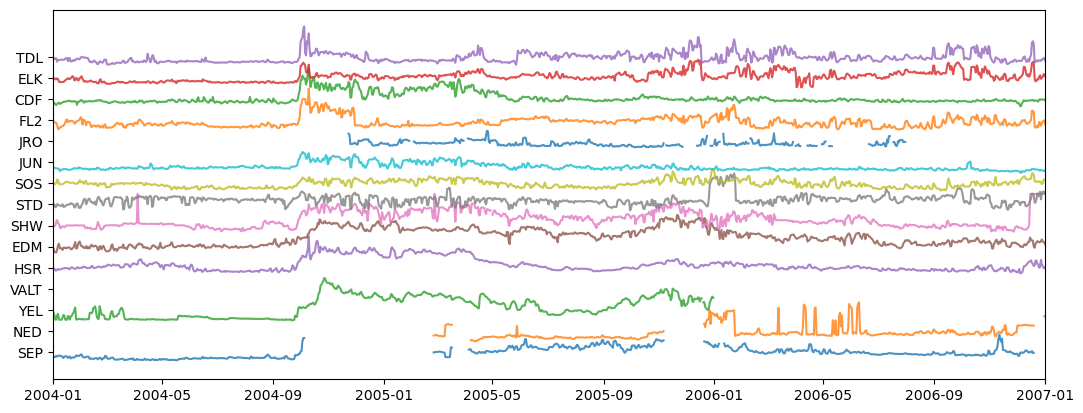

In [450]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))
for col in df_res.columns:
    ax.plot(df_res.index.to_numpy(),df_res[col].to_numpy(),alpha=0.8)

ax.set_yticks(np.arange(0.25,(len(df_res.columns))/2,0.5))
ax.set_yticklabels(df_res.columns)

ax.set_xlim(datetime.datetime(2004,1,1),datetime.datetime(2007,1,1))

# plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
# plt.legend(ncol=1, loc='upper left')
# plt.savefig('../plots/multiyear/{}_{}_RSAM_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

In [ ]:
df_zscrsam_median_res = df_zscrsam_median.resample('1D').median()
ax = df_zscrsam_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_zscrsam_median_res.columns))/2,0.5))
ax.set_yticklabels(df_zscrsam_median_res.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

# plt.savefig('../plots/multiyear/{}_{}_zscRSAM_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

In [ ]:
df_dsar_median_res = df_dsar_median.resample('1D').median()
ax = df_dsar_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_dsar_median_res.columns))/2,0.5))
ax.set_yticklabels(df_dsar_median_res.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

# plt.savefig('../plots/multiyear/{}_{}_DSAR_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

In [431]:
activity_dome = df_activity.copy()
activity_dome_start = activity_dome[activity_dome['activity' ]=='d'].take([0,2,3,4,5,6])
activity_dome_end = activity_dome[activity_dome['activity' ]=='ed'].take([1,2,3,4,5,6])
activity_dome_start, activity_dome_end

(           activity
 UTC                
 2004-10-11        d
 2004-10-25        d
 2005-01-03        d
 2005-03-19        d
 2005-08-06        d
 2005-10-09        d,
            activity
 UTC                
 2004-10-24       ed
 2004-12-18       ed
 2005-03-09       ed
 2005-07-18       ed
 2005-10-09       ed
 2006-04-01       ed)

In [432]:
df_cut = df_dsar_median.copy() # change here data to plot
# df_cut = df_cut.loc[datetime.datetime(2004,1,1):datetime.datetime(2007,1,1)]
df_res = df_cut.resample('1D').median()
ax = df_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_res.columns))/2,0.5))
ax.set_yticklabels(df_res.columns)

color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

for i in range(len(activity_dome_start)):
    sdate = activity_dome_start.index[i].to_pydatetime() # start date
    edate = activity_dome_end.index[i].to_pydatetime() # end date
#     plt.axvline(sdate, color='k',linestyle=':')
    ax.axvspan(sdate, edate, alpha=0.25, color=color[i])
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

# plt.savefig('../plots/multiyear/2000_2022_DSAR_sorted_dome3.png', dpi=300, bbox_inches='tight')

AttributeError: 'DataFrame' object has no attribute '_convert'

In [ ]:
df_zscdsar_median_res = df_zscdsar_median.resample('1D').median()
ax = df_zscdsar_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_zscdsar_median_res.columns))/2,0.5))
ax.set_yticklabels(df_zscdsar_median_res.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

plt.savefig('../plots/multiyear/{}_{}_zscDSAR_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

In [ ]:
df_rms_median_res = df_rms_median.resample('1D').median()
ax = df_rms_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_rms_median_res.columns))/2,0.5))
ax.set_yticklabels(df_rms_median_res.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

plt.savefig('../plots/multiyear/{}_{}_RMS_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

In [ ]:
df_zscrms_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

In [ ]:
df_pga_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

In [ ]:
df_zscpga_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

### Sort stations by crater distance

You need to run the import cells at the beginning of the script and the cells below the title Multi-Station Plots. Then, continue here with importing the station txt and calculate the distance to the crater station SEP. For creating the plots, use again the cells above.

In [433]:
df_dsar_median_copy = df_dsar_median.copy()
for i in range(df_dsar_median_copy.shape[1]):
    df_dsar_median_copy.iloc[:, i] = df_dsar_median_copy.iloc[:, i]+(i*0.2)
df_dsar_median_copy.plot(alpha=0.8)
plt.axvline(UTCDateTime('2004-09-23T09:00:00'), color='k',linestyle='--')
plt.legend(ncol=3, loc='upper left')

AttributeError: 'DataFrame' object has no attribute '_convert'

In [ ]:
df_zscdsar_median_copy = df_zscdsar_median.copy()
for i in range(df_zscdsar_median_copy.shape[1]):
    df_zscdsar_median_copy.iloc[:, i] = df_zscdsar_median_copy.iloc[:, i]+(i*0.2)
df_zscdsar_median_copy.plot(alpha=0.8)
plt.xlim(df_zscdsar_median_copy.index[0],df_zscdsar_median_copy.index[-1])
plt.axvline(UTCDateTime('2004-09-23T09:00:00'), color='k',linestyle='--')
plt.legend(ncol=3, loc='upper left')

In [ ]:
df_zscdsar_median_copy = df_zscdsar_median.copy()
for i in range(df_zscdsar_median_copy.shape[1]):
    df_zscdsar_median_copy.iloc[:, i] = df_zscdsar_median_copy.iloc[:, i]
df_zscdsar_median_copy.plot(alpha=0.8)
plt.xlim(df_zscdsar_median_copy.index[0],df_zscdsar_median_copy.index[-1])
plt.yscale('log')
plt.axvline(UTCDateTime('2004-09-23T09:00:00'), color='k',linestyle='--')
plt.legend(ncol=3, loc='upper left')

In [ ]:
df_zscdsar_median_copy = df_zscdsar_median.copy()
for i in range(df_zscdsar_median_copy.shape[1]):
    df_zscdsar_median_copy.iloc[:, i] = df_zscdsar_median_copy.iloc[:, i]*np.log((i+2))+np.log((i+2))
df_zscdsar_median_copy.plot(alpha=0.8)
plt.xlim(df_zscdsar_median_copy.index[0],df_zscdsar_median_copy.index[-1])
plt.yscale('log')

In [ ]:
df_dsar_median.plot(alpha=0.8)

In [ ]:
df_zscdsar_median.plot(alpha=0.8)

In [425]:
# years = range(2000,2022+1)

# df_rsam_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
# df_zscrsam_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
# df_dsar_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
# df_zscdsar_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))

# df_rms_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
# df_zscrms_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
# df_pga_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
# df_zscpga_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))


# len_dates = len(df_rsam_median)
# count = 0

# for i,sta in enumerate(sta_sorted):
#     li = []
#     len_data = 0
#     for year in years:
#         try:
#             df = pd.read_csv('../data/{}_{}_extended2.csv'.format(year,sta))
#         #     df = pd.read_csv('../data/{}_extended2_long.csv'.format(sta))
#             df.set_index('time',inplace=True)
#             df.index = pd.to_datetime(df.index).tz_localize(None)
#             df = df.resample('10min').median()
#             li.append(df)
#             len_data += len(df.index)
#         except:
# #             print(' file {}_{}_extended2.csv does not exist'.format(year,sta))
#             pass
    
#     if len_data > len_dates*0.25: # percent of avivable data
#         df = pd.concat(li)


#         df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)

#         df = df.rolling('6H', center=True).median()
#         df['rsam_median'] = df['rsam'].rolling('2D').median()
#         df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
#         df['dsar_median'] = df['dsar'].rolling('2D').median()
#         df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
#         df['rms_median'] = df['rms'].rolling('2D').median()
#         df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
#         df['pga_median'] = df['pga'].rolling('2D').median()
#         df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()
#     #     df = df.resample('1H').median()

#         df = df.apply(norm,axis=0) # normalize all timesiries individual

#         df += count*0.5 # to get offset

#         df_rsam_median['{}'.format(sta)] = df['rsam_median']
#         df_zscrsam_median['{}'.format(sta)] = df['zsc2_rsam_median']
#         df_dsar_median['{}'.format(sta)] = df['dsar_median']
#         df_zscdsar_median['{}'.format(sta)] = df['zsc2_dsar_median']

#         df_rms_median['{}'.format(sta)] = df['rms_median']
#         df_zscrms_median['{}'.format(sta)] = df['zsc2_rms_median']
#         df_pga_median['{}'.format(sta)] = df['pga_median']
#         df_zscpga_median['{}'.format(sta)] = df['zsc2_pga_median']
        
#         count += 1
#     else:
#         pass
    
#     sys.stdout.write('\r{} of {}'.format(i+1, len(sta_list)))
#     sys.stdout.flush()
# print('\nDONE')

29 of 29
DONE
